<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C2/W2/ungraded_labs/C2_W2_Lab_1_cats_v_dogs_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Baseline Performance

You will start with a model that's very effective at learning `Cats vs Dogs` without data augmentation. It's similar to the previous models that you have used. Note that there are four convolutional layers with 32, 64, 128 and 128 convolutions respectively. The code is basically the same from the previous lab so we won't go over the details step by step since you've already seen it before.

You will train only for 20 epochs to save time but feel free to increase this if you want.

In [10]:
# Download the dataset
# !wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

In [4]:
from helper import *
import os
import sys
from pathlib import Path
import zipfile

In [2]:
url = "https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip"

zip_file_path = Path('data/cats_and_dogs.zip')
extract_path = Path('data/')

download_zip_file(url,zip_file_path)

Download successful. File saved at data\cats_and_dogs.zip


In [6]:
import os
import zipfile

# Extract the archive
zip_ref = zipfile.ZipFile(zip_file_path, 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

In [7]:
# Assign training and validation set directories
base_dir = 'tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [17]:
tr_cats = len(os.listdir(train_cats_dir))
tr_dogs = len(os.listdir(train_dogs_dir))

vl_cats = len(os.listdir(validation_cats_dir))
vl_dogs = len(os.listdir(validation_dogs_dir))

print("Length of training for CATS is ",tr_cats,"and for DOGS",tr_dogs)
print("Length of Validation for CATS is ", vl_cats, "and for DOGS",vl_dogs)

Length of training for CATS is  1000 and for DOGS 1000
Length of Validation for CATS is  500 and for DOGS 500


You will place the model creation inside a function so you can easily initialize a new one when you use data augmentation later in this notebook.

In [99]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop


def create_model():
    '''Creates a CNN with 4 convolutional layers'''
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(
            32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        # Use softmax activation for categorical labels
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(learning_rate=1e-4),
                  metrics=['binary_accuracy'])

    return model

In [131]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [108]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=["cats", "dogs"],
    color_mode='rgb',
    batch_size=20,
    image_size=(150, 150),
    shuffle=True,
    seed=99,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=["cats", "dogs"],
    color_mode='rgb',
    batch_size=20,  # CONFIGURATION["BATCH_SIZE"],
    image_size=(150, 150),
    shuffle=True,
    seed=99,
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [127]:
tf_2d = tf.constant(
    [[1, 2, 3],
     [1, 2, 3],
     [1, 2, 3]],
    dtype="float32",
)
tf_2d[:,-1:]

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[3.],
       [3.],
       [3.]], dtype=float32)>

In [123]:
def resize_rescale(image, label):
    image = tf.cast(image, tf.float32) / 255.
    return tf.squeeze(image), tf.squeeze(tf.squeeze(label)[:, -1:])

In [124]:
train_data = (train_dataset.map(resize_rescale)
              .shuffle(buffer_size=512, reshuffle_each_iteration=True)
              .prefetch(tf.data.AUTOTUNE))

val_data = (val_dataset.map(resize_rescale)
              .shuffle(buffer_size=512, reshuffle_each_iteration=True)
              .prefetch(tf.data.AUTOTUNE))


In [125]:
list(train_data.take(1).as_numpy_iterator())[0][1].shape

(20,)

In [128]:
# Constant for epochs
EPOCHS = 20

# Create a new model
model = create_model()

# Train the model
history = model.fit(
    train_data,
    steps_per_epoch=100,  # 2000 images = batch_size * steps
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=50,  # 1000 images = batch_size * steps
    verbose=2)

Epoch 1/20
100/100 - 37s - loss: 0.6940 - binary_accuracy: 0.5195 - val_loss: 0.6860 - val_binary_accuracy: 0.5780 - 37s/epoch - 373ms/step
Epoch 2/20
100/100 - 37s - loss: 0.6811 - binary_accuracy: 0.5510 - val_loss: 0.6803 - val_binary_accuracy: 0.5190 - 37s/epoch - 372ms/step
Epoch 3/20
100/100 - 38s - loss: 0.6609 - binary_accuracy: 0.6040 - val_loss: 0.6446 - val_binary_accuracy: 0.6400 - 38s/epoch - 385ms/step
Epoch 4/20
100/100 - 35s - loss: 0.6335 - binary_accuracy: 0.6415 - val_loss: 0.6211 - val_binary_accuracy: 0.6650 - 35s/epoch - 349ms/step
Epoch 5/20
100/100 - 33s - loss: 0.5962 - binary_accuracy: 0.6640 - val_loss: 0.5901 - val_binary_accuracy: 0.6810 - 33s/epoch - 332ms/step
Epoch 6/20
100/100 - 33s - loss: 0.5662 - binary_accuracy: 0.7090 - val_loss: 0.6388 - val_binary_accuracy: 0.6260 - 33s/epoch - 330ms/step
Epoch 7/20
100/100 - 33s - loss: 0.5415 - binary_accuracy: 0.7305 - val_loss: 0.5573 - val_binary_accuracy: 0.7090 - 33s/epoch - 332ms/step
Epoch 8/20
100/100 -

In [132]:
# Constant for epochs
EPOCHS = 20

# Create a new model
model = create_model()

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/20
100/100 - 42s - loss: 0.6943 - binary_accuracy: 0.4995 - val_loss: 0.6877 - val_binary_accuracy: 0.6040 - 42s/epoch - 421ms/step
Epoch 2/20
100/100 - 40s - loss: 0.6902 - binary_accuracy: 0.5410 - val_loss: 0.6774 - val_binary_accuracy: 0.5590 - 40s/epoch - 402ms/step
Epoch 3/20
100/100 - 45s - loss: 0.6810 - binary_accuracy: 0.5535 - val_loss: 0.6575 - val_binary_accuracy: 0.6110 - 45s/epoch - 447ms/step
Epoch 4/20
100/100 - 46s - loss: 0.6682 - binary_accuracy: 0.5940 - val_loss: 0.6449 - val_binary_accuracy: 0.6550 - 46s/epoch - 460ms/step
Epoch 5/20
100/100 - 43s - loss: 0.6541 - binary_accuracy: 0.6105 - val_loss: 0.6240 - val_binary_accuracy: 0.6480 - 43s/epoch - 431ms/step
Epoch 6/20
100/100 - 46s - loss: 0.6365 - binary_accuracy: 0.6295 - val_loss: 0.6068 - val_binary_accuracy: 0.6720 - 46s/epoch - 459ms/step
Epoch 7/20
100/100 - 42s - loss: 0.6264 - binary_accuracy: 0.6360 - val_loss: 0.5845 - val_binary_accuracy: 0.6850 - 42s/epoch - 421ms/step
Epoch 8/20
100/100 -

You will then visualize the loss and accuracy with respect to the training and validation set. You will again use a convenience function so it can be reused later. This function accepts a [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object which contains the results of the `fit()` method you ran above.

In [135]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [136]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

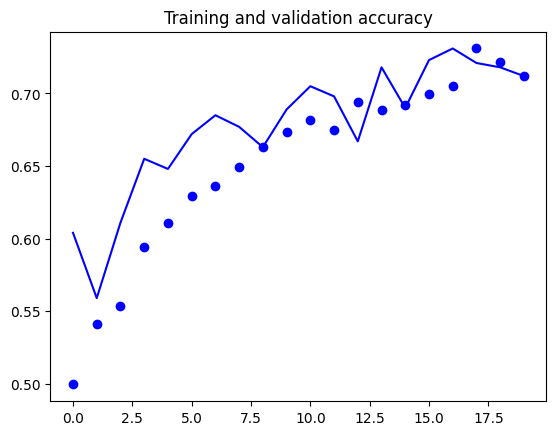

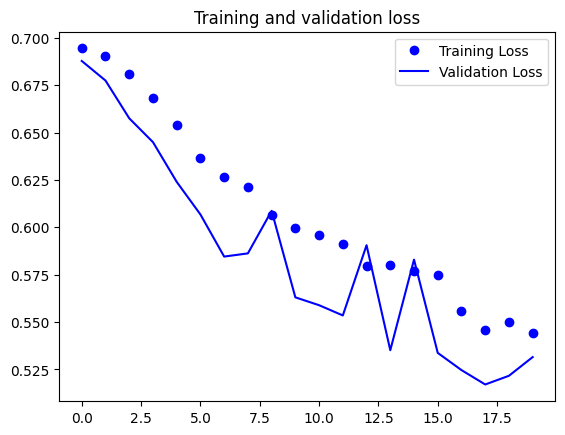

In [137]:
# Plot training results
plot_loss_acc(history)